- Link 1: https://www.kaggle.com/code/divyanshnautiyal/disaster-tweets --> 0.7919
- Link 2: https://www.kaggle.com/code/andreaskaufmann/distillbert-tweet-classification --> 0.8296
- Link 3: https://www.kaggle.com/code/xuezeng/disaster-tweets-bert --> 0.832
- Link 4: https://www.kaggle.com/code/zakharsmirnoff/nlp-for-twitter-disaster-competition --> 0.82

# Thành viên nhóm
| Họ và tên      | MSSV |
| ----------- | ----------- |
| Nguyễn Phú Thụ| 19120673|
| Ngô Mậu Trường | 19120699 |
| Lê Anh Vũ| 19120724|
| Nguyễn Đức Minh Quân | 20120357|

# 1. Mô tả dữ liệu 
- <span style="font-size:17px;font-family: Times New Roman;"> Sự phổ biến của smartphone cho phép mọi người thông báo trường hợp khẩn cấp mà họ đang quan sát thấy trong thời gian thực lên mạng xã hội. Và Twitter là một kênh liên lạc quan trọng trong trường hợp khẩn cấp. </span>
- <span style="font-size:17px;font-family: Times New Roman;"> Do đó, nhiều cơ quan quan tâm đến việc theo dõi Twitter. Tuy nhiên, không phải lúc nào bài đăng của một người cũng thông báo rõ ràng về một thảm họa và có nhiều trường hợp gây hiểu nhầm. </span>
- <span style="font-size:17px;font-family: Times New Roman;">Ý nghĩa các trường thuộc tính trong dataset:</span>
    | Syntax      | Description |
    | ----------- | ----------- |
    | id | giúp định danh cho từng tweet |
    | text   | nội dung của bài tweet |
    | location | vị trí của bài tweet đăng, có thể để trống |
    | education | một từ khóa cụ thể của bài tweet, có thể để trống   |
    | target | thể hiện bài tweet có phải thảm họa hay không (1) là disaster và ngược lại. |

# 2. Khám phá và tiền xử lý dữ liệu

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score, accuracy_score
from string import punctuation
from nltk.corpus import stopwords
import nltk
import re


sns.set_theme('notebook')
warnings.filterwarnings("ignore")

In [99]:
train_twitter_df = pd.read_csv('dataset/train.csv')
test_twitter_df = pd.read_csv('dataset/test.csv')
train_twitter_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## 2.1 Dữ liệu có bao nhiêu dòng, cột ?

In [11]:
print(f'Dữ liệu có {train_twitter_df.shape[0]} dòng')
print(f'Dữ liệu có {train_twitter_df.shape[1]} cột')

Dữ liệu có 7613 dòng
Dữ liệu có 5 cột


## 2.2 Dữ liệu có bị trùng hay không ?

In [12]:
train_twitter_df.duplicated().sum()

0

## 2.3 Dữ liệu có bị thiếu không ? 

In [15]:
train_twitter_df.isna().sum(axis = 0)

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

<span style="font-size:18px;font-family: Times New Roman;"> **Nhận xét** </span>
- <span style="font-size:17px;font-family: Times New Roman;"> Giá trị bị thiếu khá nhiều ở location và một số ở keyword, nhóm sẽ trực quan để xem nhóm tỷ lệ target của tập dữ liệu bị thiếu. </span>

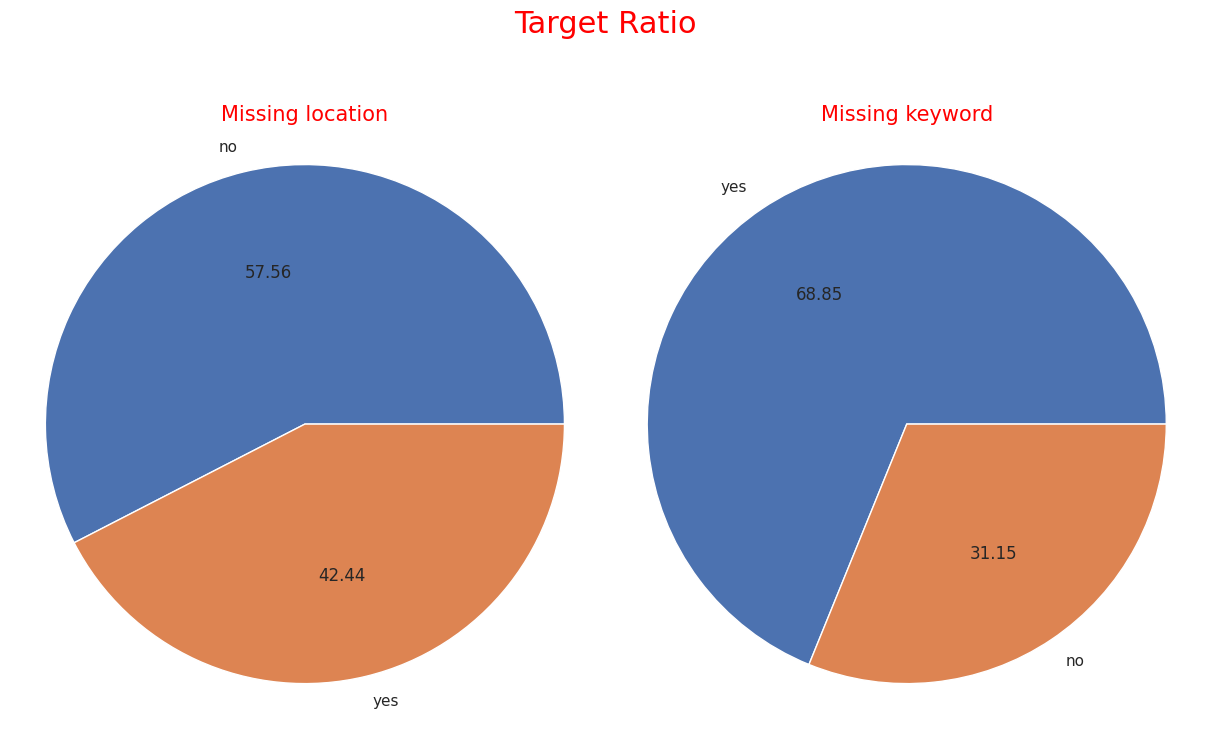

In [41]:
fig, axs = plt.subplots(1,2,figsize = (12,8), constrained_layout = True)
location_stats = train_twitter_df.loc[train_twitter_df['location'].isna(), 'target'].value_counts()
keyword_stats = train_twitter_df.loc[train_twitter_df['keyword'].isna(), 'target'].value_counts()
axs[0].pie(labels=['no', 'yes'], x = location_stats.values, autopct='%.2f', radius=1.1)
axs[1].pie(labels=['yes', 'no'], x = keyword_stats.values, autopct='%.2f', radius=1.1)

axs[0].set_title("Missing location", fontsize = 15, color='red')
axs[1].set_title("Missing keyword", fontsize = 15, color='red')
plt.suptitle('Target Ratio', fontsize = 22, color = 'red')
plt.show()

<span style="font-size:18px;font-family: Times New Roman;"> **Nhận xét** </span>
- <span style="font-size:17px;font-family: Times New Roman;"> Số lượng keyword bị thiếu không đáng kể nên nhóm sẽ xóa nhưng dòng bị thiếu giá trị keyword. </span>
- <span style="font-size:17px;font-family: Times New Roman;"> Số lượng location bị thiếu tương đối nhiều nhưng khi so sánh tỷ lệ giữa target = 1 và target = 0 thì tỷ lệ này chênh lệch không đáng kể. Nên riêng với cột location, nhóm sẽ xem NaN như một giá trị. </span>

## 2.4 Phân tích cột keyword

In [90]:
# remove missing keyword
train_twitter_df = train_twitter_df[train_twitter_df['keyword'].notna()].reset_index().drop(columns = 'index')

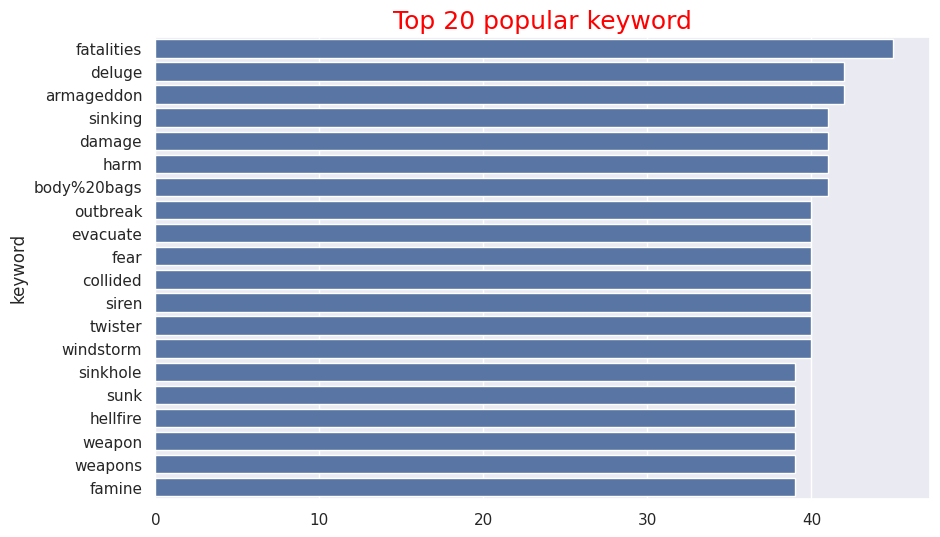

In [100]:
plt.rcParams['figure.figsize'] = (10,6)
keyword_stats2 = train_twitter_df['keyword'].value_counts().head(20)
sns.barplot(y = keyword_stats2.index, x = keyword_stats2.values, color='b')
plt.title("Top 20 popular keyword", fontsize = 18, color = 'red')
plt.show()

<span style="font-size:18px;font-family: Times New Roman;"> **Nhận xét** </span>
- <span style="font-size:17px;font-family: Times New Roman;">Đa số keyword điều liên quan đến các hiện tượng thời tiết như: deluged, snowstorm,... và các tính từ cảm thán như catastrophe, annihilation,...  </span>
- <span style="font-size:17px;font-family: Times New Roman;">Nhóm nhận thấy keyword chứa các giá trị đặc biệt %20 (khoảng trắng), nhóm sẽ tiền xử lý phần này.</span>

In [65]:
# ví dụ %20
train_twitter_df.loc[train_twitter_df['keyword'].str.contains('wild'), 'keyword'].value_counts()

keyword
wildfire        33
wild%20fires    31
Name: count, dtype: int64

In [101]:
def keyword_preprocess(text):
    """ removing '%20' """
    if pd.notnull(text):
        text = text.replace("%20", " ")
    else:
        text = ''
  
    return text

In [103]:
train_twitter_df['keyword'] = train_twitter_df['keyword'].apply(keyword_preprocess)
test_twitter_df['keyword'] = test_twitter_df['keyword'].apply(keyword_preprocess)

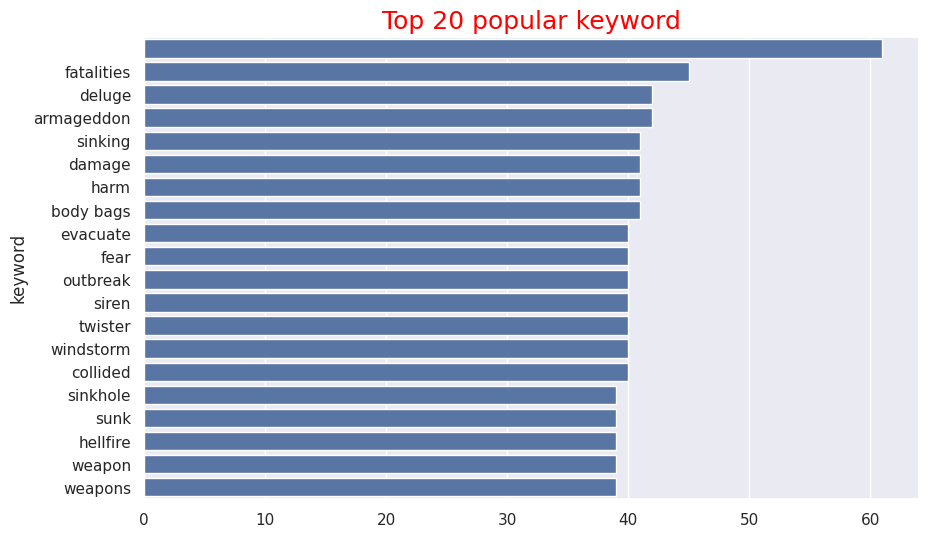

In [104]:
plt.rcParams['figure.figsize'] = (10,6)
keyword_stats2 = train_twitter_df['keyword'].value_counts().head(20)
sns.barplot(y = keyword_stats2.index, x = keyword_stats2.values, color='b')
plt.title("Top 20 popular keyword", fontsize = 18, color = 'red')
plt.show()

## 2.5 Phân tích cột location

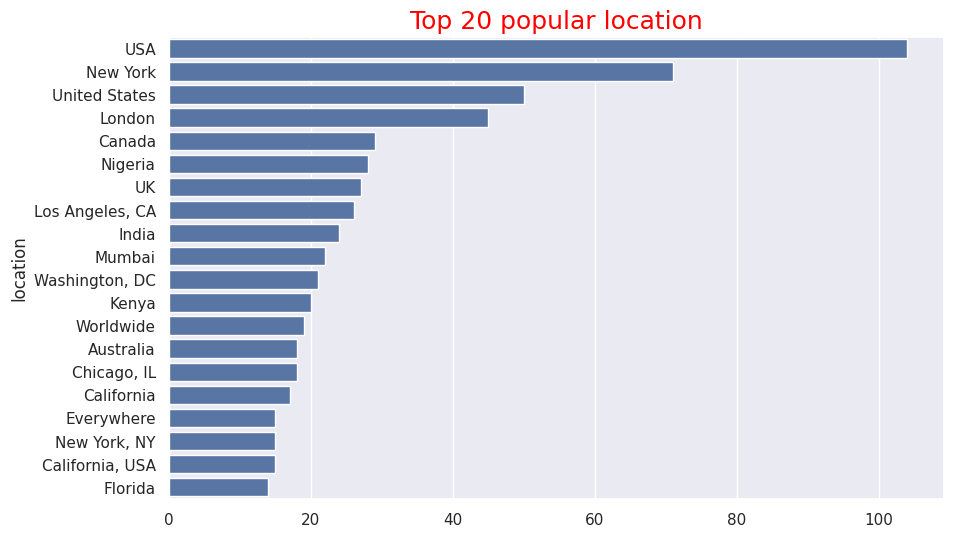

In [114]:
plt.rcParams['figure.figsize'] = (10,6)
location_stats2 = train_twitter_df['location'].value_counts().head(20)
sns.barplot(y = location_stats2.index, x = location_stats2.values, color='b')
plt.title("Top 20 popular location", fontsize = 18, color = 'red')
plt.show()

In [113]:
location_stats2.index.to_list()

['USA',
 'New York',
 'United States',
 'London',
 'Canada',
 'Nigeria',
 'UK',
 'Los Angeles, CA',
 'India',
 'Mumbai',
 'Washington, DC',
 'Kenya',
 'Worldwide',
 'Australia',
 'Chicago, IL',
 'California',
 'Everywhere',
 'New York, NY',
 'California, USA',
 'Florida',
 'San Francisco',
 'United Kingdom',
 'Los Angeles',
 'Indonesia',
 'Washington, D.C.',
 'Toronto',
 'NYC',
 'Ireland',
 'Seattle',
 'Earth',
 'San Francisco, CA',
 'Chicago',
 'Texas',
 'London, England',
 'Sacramento, CA',
 'New York City',
 'London, UK',
 'Atlanta, GA',
 'ss',
 'Dallas, TX',
 'San Diego, CA',
 'US',
 'Denver, Colorado',
 'Manchester',
 '304',
 'World',
 'Nashville, TN',
 'South Africa',
 'Scotland',
 'Houston, TX',
 'Denver, CO',
 'Tennessee',
 'Seattle, WA',
 'Sydney',
 'Austin, TX',
 'worldwide',
 'Memphis, TN',
 'Pennsylvania, USA',
 'Massachusetts',
 'Morioh, Japan',
 'Portland, OR',
 'Oklahoma City, OK',
 'Planet Earth',
 'Global',
 'California, United States',
 'Colorado',
 'Orlando, FL',
 'A

In [ ]:
@, emoji

In [119]:
deEmojify('\x89Û¢III.XII.MMXI\x89Û¢')

'III.XII.MMXI'

In [116]:
deEmojify('lia\x89Û¢dani\x89Û¢laura')

'liadanilaura'

In [115]:
def deEmojify(inputString):
    return inputString.encode('ascii','ignore').decode('ascii')
def hasNumber(string):
    return any(char.isdigit() for char in string)

In [19]:
nltk.download("stopwords")
stopword=stopwords.words('english')
stopword.remove('not')

[nltk_data] Downloading package stopwords to /home/eplus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
